# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

*сделала Бельченко Алиса БВСН231*

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:45<00:00, 3.72MB/s] 


Посмотрим на изображения:

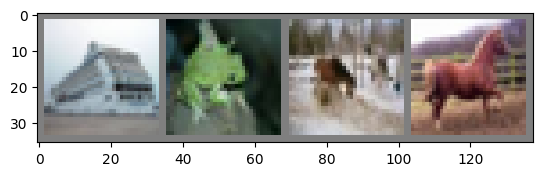

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

In [6]:
images[0].shape

torch.Size([3, 32, 32])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [10]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
        )

        self.skip = nn.Conv2d(3, 32, kernel_size=1)

        self.pool = nn.AvgPool2d(kernel_size=8)

        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        out = self.main(x)
        out = out + self.skip(x)
        out = torch.relu(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [11]:
net = BasicBlockNet()
net

BasicBlockNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [12]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [13]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(device)

mps


In [14]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [17]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
            loss_log.append(loss.item())
        
            acc = (output.argmax(dim=1) == target).float().mean()
        
            acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).float().mean()
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [18]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4675320990560696, train acc: 0.48050649652097516
 val loss: 1.2074303185686153, val acc: 0.577437943346957

Epoch 1
 train loss: 1.1324696690116547, train acc: 0.6047597283419133
 val loss: 1.109144062184273, val acc: 0.6159352837724889

Epoch 2
 train loss: 1.045618513057611, train acc: 0.635356816447849
 val loss: 1.1122983922349645, val acc: 0.6148271276595745

Epoch 3
 train loss: 0.9957055318726046, train acc: 0.6551359689213894
 val loss: 1.0929592804705843, val acc: 0.6153812057160316

Epoch 4
 train loss: 0.9551496361901599, train acc: 0.6676351528281049
 val loss: 1.0012181609234911, val acc: 0.6549645390916378

Epoch 5
 train loss: 0.924725908574936, train acc: 0.6802322734862403
 val loss: 0.9957868170230947, val acc: 0.657624113559723

Epoch 6
 train loss: 0.8959938768277003, train acc: 0.6886303539249972
 val loss: 0.9267219084374448, val acc: 0.6793218085106383

Epoch 7
 train loss: 0.8875055064666859, train acc: 0.6923111451609261
 val loss: 0.9175

Посчитайте точность на тестовой выборке:

In [19]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

 test loss: 0.8649269539839143, test acc: 0.7067078025477707



Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

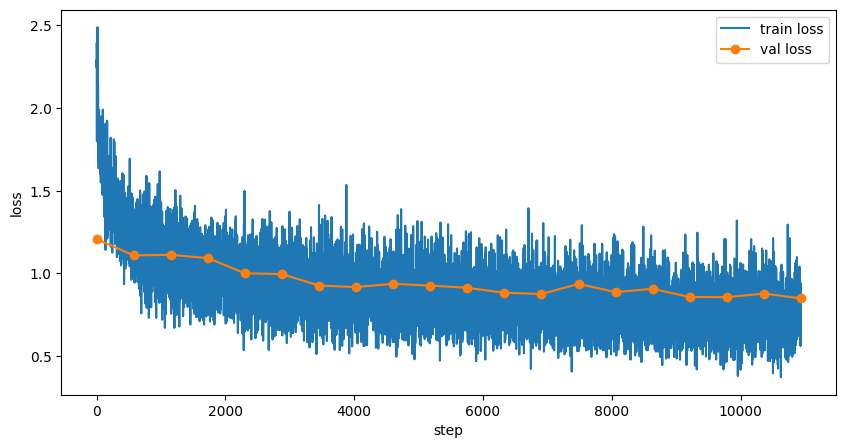

In [20]:
train_steps = np.arange(len(train_loss_log))
val_steps = np.linspace(0, len(train_loss_log), len(val_loss_log))

plt.figure(figsize=(10,5))
plt.plot(train_steps, train_loss_log, label='train loss')
plt.plot(val_steps, val_loss_log, label='val loss', marker='o')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()
plt.show()

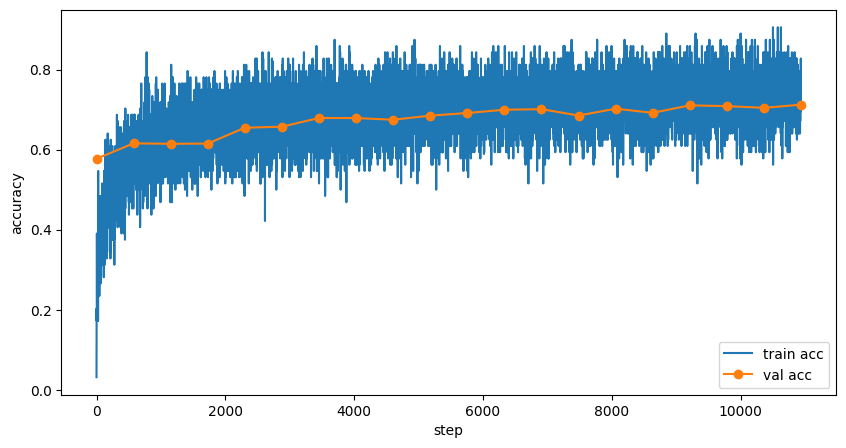

In [21]:
plt.figure(figsize=(10,5))
plt.plot(train_steps, train_acc_log, label='train acc')
plt.plot(val_steps, val_acc_log, label='val acc', marker='o')
plt.xlabel('step')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4918591775667516, train acc: 0.46931721730467607
 val loss: 1.2848000290546011, val acc: 0.554565602921425

Epoch 1
 train loss: 1.1698462510893506, train acc: 0.5917545377227462
 val loss: 1.0944949888168498, val acc: 0.6152925531914893

Epoch 2
 train loss: 1.0399920274614198, train acc: 0.6390172042620029
 val loss: 1.0460127929423717, val acc: 0.638652482184958

Epoch 3
 train loss: 0.9884698507554788, train acc: 0.6560786106032906
 val loss: 0.9773786349499479, val acc: 0.6625

Epoch 4
 train loss: 0.947537197818268, train acc: 0.6734460694698354
 val loss: 1.0166466157487097, val acc: 0.6521498226104898

Epoch 5
 train loss: 0.9225006277861935, train acc: 0.6816074693442699
 val loss: 0.9724714834639366, val acc: 0.669126773134191

Epoch 6
 train loss: 0.901405592941061, train acc: 0.6870592844551616
 val loss: 0.9335046032641796, val acc: 0.6756427305809996

Epoch 7
 train loss: 0.8791121321796717, train acc: 0.6934088535021167
 val loss: 0.913864006133789

Посчитайте точность на тестовой выборке:

In [23]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

 test loss: 0.8208376169204712, test acc: 0.7185509554140127



**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.806516598957766, train acc: 0.3705357142623643
 val loss: 1.585404253513255, val acc: 0.4436391844394359

Epoch 1
 train loss: 1.5192187671469597, train acc: 0.4654283102949097
 val loss: 1.437051089773787, val acc: 0.48984929082241463

Epoch 2
 train loss: 1.4095804087640598, train acc: 0.5030442021882512
 val loss: 1.3657320616093087, val acc: 0.5162234042553191

Epoch 3
 train loss: 1.342557985124466, train acc: 0.5290668255886168
 val loss: 1.3043895082270844, val acc: 0.5370124113052449

Epoch 4
 train loss: 1.2889272601120652, train acc: 0.547658494338257
 val loss: 1.268412157322498, val acc: 0.5533023050490846

Epoch 5
 train loss: 1.2408691699151801, train acc: 0.5642751044503513
 val loss: 1.223022343503668, val acc: 0.5694148936170212

Epoch 6
 train loss: 1.200066302005726, train acc: 0.5816588861632827
 val loss: 1.173371887460668, val acc: 0.5900265957446809

Epoch 7
 train loss: 1.159944062477056, train acc: 0.5970104792218321
 val loss: 1.13704446

In [25]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

 test loss: 0.9802222965629237, test acc: 0.6578423566878981



**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [26]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.4498904072824301, train acc: 0.48207348519748916
 val loss: 1.4485696919420932, val acc: 0.517686170212766

Epoch 1
 train loss: 1.138093814117599, train acc: 0.60302135026869
 val loss: 1.0696614985770367, val acc: 0.6295877659574468

Epoch 2
 train loss: 1.0335309639491372, train acc: 0.6404250457038391
 val loss: 1.051610166468519, val acc: 0.6326462765957447

Epoch 3
 train loss: 0.9691949160922816, train acc: 0.6633422564326954
 val loss: 0.9923926284972657, val acc: 0.6586436170212766

Epoch 4
 train loss: 0.9389664224558382, train acc: 0.6725360733717407
 val loss: 1.0901103108487231, val acc: 0.6278590425531915

Epoch 5
 train loss: 0.9053697223201312, train acc: 0.6869980738629371
 val loss: 0.9279794870538914, val acc: 0.6835328013338942

Epoch 6
 train loss: 0.8852869429143735, train acc: 0.6900014690986717
 val loss: 0.9330284296198094, val acc: 0.6817597518575952

Epoch 7
 train loss: 0.7782661032742076, train acc: 0.7318898537477148
 val loss: 0.844

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.5195904922223833, train acc: 0.4580993731889254
 val loss: 1.275144850193186, val acc: 0.5458333333756061

Epoch 1
 train loss: 1.1938593555412083, train acc: 0.5784024876258055
 val loss: 1.1737047164998156, val acc: 0.5884308510638298

Epoch 2
 train loss: 1.0649818528504869, train acc: 0.6302273765996343
 val loss: 1.0048622704566794, val acc: 0.6549645390916378

Epoch 3
 train loss: 1.013897581226865, train acc: 0.6463624641054073
 val loss: 0.9774976874919648, val acc: 0.6592420212765957

Epoch 4
 train loss: 0.9624215149792282, train acc: 0.6653826064557872
 val loss: 1.0121260402050425, val acc: 0.6519281914893617

Epoch 5
 train loss: 0.9309586941433127, train acc: 0.6762046226635712
 val loss: 0.9924166489154734, val acc: 0.6542109928232558

Epoch 6
 train loss: 0.8995614721962477, train acc: 0.6871694632596465
 val loss: 0.931139652526125, val acc: 0.6796320922831272

Epoch 7
 train loss: 0.8699557524058675, train acc: 0.6963673608830467
 val loss: 0.96

In [28]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.4945976099976674, train acc: 0.46688512011245575
 val loss: 1.2524056244403758, val acc: 0.5598404255319149

Epoch 1
 train loss: 1.1699226074724354, train acc: 0.588951096892139
 val loss: 1.1277248813750895, val acc: 0.6049867021276596

Epoch 2
 train loss: 1.0475991050111746, train acc: 0.63344704886895
 val loss: 1.0013336338895433, val acc: 0.652127659574468

Epoch 3
 train loss: 0.9790907460767129, train acc: 0.6590289566155108
 val loss: 1.0082741463437994, val acc: 0.6494015957446808

Epoch 4
 train loss: 0.9442653136235922, train acc: 0.6690144293704896
 val loss: 0.9841842943049491, val acc: 0.6597960992062345

Epoch 5
 train loss: 0.9088864637031415, train acc: 0.683786563071298
 val loss: 0.943628505189368, val acc: 0.6757535460147451

Epoch 6
 train loss: 0.8835866620161416, train acc: 0.6935353551529879
 val loss: 0.9284792907694552, val acc: 0.6805851063829788

Epoch 7
 train loss: 0.8579292506578854, train acc: 0.704157417064611
 val loss: 0.91627

Your answers here: 
1) StepLR снижает каждые 7 эпох в 5 раз (в нашем случае) - немного улучшил по сравнению с отсутсвием шедулера, но не лучше чем MultiStepLR
2) CosineAnnealingLR линейно уменьшает lr по косинусоидальной кривой от начального до минимального значения в течение 20 эпох - аналогично StepLR в плане улучшения
3) ExponentialLR уменьшает learning rate экспоненциально на каждой эпохе, то есть на каждой эпохе lr = lr * gamma, тоже не удалось улучшить больше чем MultiStepLR

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

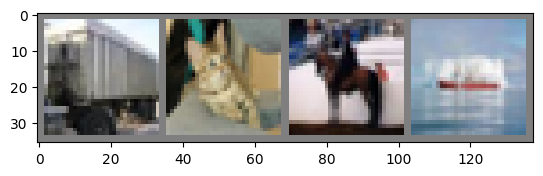

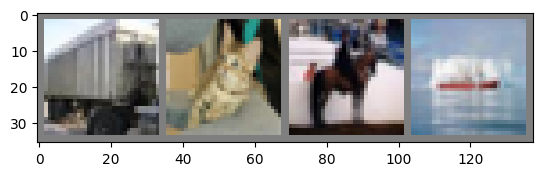

In [30]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [31]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4813555537891563, train acc: 0.4726103421103148
 val loss: 1.276956771789713, val acc: 0.5419547872340426

Epoch 1
 train loss: 1.1814427180743523, train acc: 0.5856865369859517
 val loss: 1.1006936032721337, val acc: 0.6201462765957447

Epoch 2
 train loss: 1.057044106384082, train acc: 0.6315291199213408
 val loss: 1.0554420405245841, val acc: 0.6341755319148936

Epoch 3
 train loss: 0.9948536512838639, train acc: 0.6539321624600691
 val loss: 1.0137740064174572, val acc: 0.6526595744680851

Epoch 4
 train loss: 0.9577346320997863, train acc: 0.6701570253485517
 val loss: 1.0078472588924652, val acc: 0.6468306736743197

Epoch 5
 train loss: 0.9261103217954827, train acc: 0.6780980673960837
 val loss: 0.9282647503183243, val acc: 0.6755762412192974

Epoch 6
 train loss: 0.9070256834056303, train acc: 0.688275332969547
 val loss: 0.9994766554933914, val acc: 0.6513519502700643

Epoch 7
 train loss: 0.8974963910400976, train acc: 0.6873979824552588
 val loss: 0.89

Посчитайте точность на тестовой выборке:

In [32]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

 test loss: 0.8071125051018538, test acc: 0.7247213375796179



**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

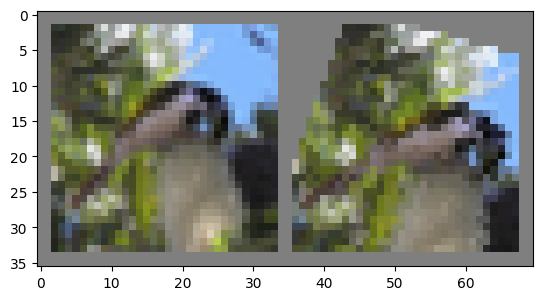

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

affined = transforms.functional.affine(images[0], angle=15, translate=(3, 3), scale=1.1, shear=5)

imshow(torchvision.utils.make_grid([images[0], affined]))

In [43]:
transform = transforms.Compose(
        [transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.6990333313915804, train acc: 0.38519358841984974
 val loss: 1.5369851193529493, val acc: 0.4401374113052449

Epoch 1
 train loss: 1.4856833202093567, train acc: 0.4666157939098435
 val loss: 1.394504336600608, val acc: 0.498936170212766

Epoch 2
 train loss: 1.3960059340736766, train acc: 0.50252187257493
 val loss: 1.3503012340119545, val acc: 0.517265070879713

Epoch 3
 train loss: 1.3267057215491858, train acc: 0.5241128558214665
 val loss: 1.3480489771416846, val acc: 0.5329122340425532

Epoch 4
 train loss: 1.2706088520709078, train acc: 0.5495805040247044
 val loss: 1.367188517083513, val acc: 0.5106382978723404

Epoch 5
 train loss: 1.2333619010513837, train acc: 0.5626224209665163
 val loss: 1.2301457412699435, val acc: 0.5629432624958931

Epoch 6
 train loss: 1.2037774734130944, train acc: 0.574105510546041
 val loss: 1.1793460447737512, val acc: 0.5829343972053934

Epoch 7
 train loss: 1.1798754471747488, train acc: 0.5841562744686329
 val loss: 1.17602

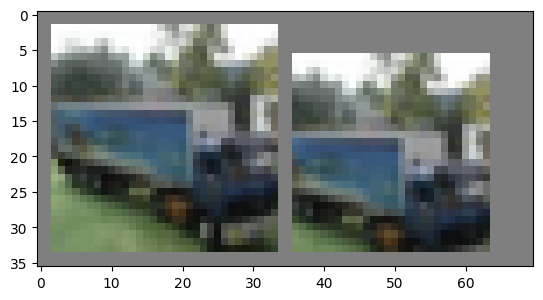

In [41]:
import random

padded = F.pad(images[1], pad=(4, 4, 4, 4))

i = random.randint(0, 40 - 32)
j = random.randint(0, 40 - 32)

cropped = transforms.functional.crop(padded, top=i, left=j, height=32, width=32)

imshow(torchvision.utils.make_grid([images[1], cropped]))

In [44]:
transform = transforms.Compose(
        [transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.668072491284916, train acc: 0.39158396447380456
 val loss: 1.5301191766211326, val acc: 0.43450797872340424

Epoch 1
 train loss: 1.3904493138384775, train acc: 0.5004366348604833
 val loss: 1.2610616242631953, val acc: 0.5512411348363186

Epoch 2
 train loss: 1.2396894073355569, train acc: 0.5615328741030022
 val loss: 1.1851271543096988, val acc: 0.5846409574468086

Epoch 3
 train loss: 1.1765452636443283, train acc: 0.5860252350950154
 val loss: 1.201052516572019, val acc: 0.5794547872340425

Epoch 4
 train loss: 1.1317473977967634, train acc: 0.6018705928674346
 val loss: 1.2776149130882102, val acc: 0.5593528369639782

Epoch 5
 train loss: 1.109132524709161, train acc: 0.60984428044429
 val loss: 1.1182148872537816, val acc: 0.6061613476022761

Epoch 6
 train loss: 1.0758319460059869, train acc: 0.6230045377227462
 val loss: 1.082789596598199, val acc: 0.6227171986661059

Epoch 7
 train loss: 1.0611901903283225, train acc: 0.6270240271767054
 val loss: 1.074

In [47]:
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.5381816143963412, train acc: 0.45489602376599636
 val loss: 1.3349061024949906, val acc: 0.5267065602414152

Epoch 1
 train loss: 1.215117059634416, train acc: 0.5739218790962666
 val loss: 1.1405142378299795, val acc: 0.6038563829787233

Epoch 2
 train loss: 1.105495918276541, train acc: 0.614430987202925
 val loss: 1.0740371384519212, val acc: 0.6297429077168728

Epoch 3
 train loss: 1.0455411323899544, train acc: 0.63849895538752
 val loss: 1.163172994775975, val acc: 0.605873226865809

Epoch 4
 train loss: 1.0095266019840345, train acc: 0.6521733807471378
 val loss: 1.0856201346884382, val acc: 0.6220966312479466

Epoch 5
 train loss: 0.9797831949193909, train acc: 0.6611141942754742
 val loss: 0.9779637955604715, val acc: 0.6643395390916378

Epoch 6
 train loss: 0.9571651500365416, train acc: 0.6678881561298475
 val loss: 1.0169315875844753, val acc: 0.651529255319149

Epoch 7
 train loss: 0.9457260686257204, train acc: 0.6734256659390939
 val loss: 1.048271

In [49]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=10, fill=0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.5210309671527507, train acc: 0.4556183076209952
 val loss: 1.3220336503170906, val acc: 0.5180851063829788

Epoch 1
 train loss: 1.235136557213785, train acc: 0.5665643770908307
 val loss: 1.1379991204180615, val acc: 0.599312943346957

Epoch 2
 train loss: 1.122132055938135, train acc: 0.6091301579580011
 val loss: 1.1365122112822026, val acc: 0.6058067375041069

Epoch 3
 train loss: 1.0563460251748888, train acc: 0.6317372355862118
 val loss: 1.0321927303963518, val acc: 0.6424202127659574

Epoch 4
 train loss: 1.0185681871347934, train acc: 0.644583278970701
 val loss: 1.0418101079920505, val acc: 0.6370345744680851

Epoch 5
 train loss: 0.9829270792835592, train acc: 0.6588412444813814
 val loss: 1.026797445784224, val acc: 0.6360815603682335

Epoch 6
 train loss: 0.9532255284093197, train acc: 0.6667169952523337
 val loss: 0.9703079923670342, val acc: 0.6646941489361702

Epoch 7
 train loss: 0.9384218068619751, train acc: 0.6701978323010683
 val loss: 1.0205

In [50]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.03),
         transforms.RandomRotation(degrees=5, fill=0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}\n")

Epoch 0
 train loss: 1.4963940551991437, train acc: 0.467668614505196
 val loss: 1.2700589755748182, val acc: 0.5451462765957447

Epoch 1
 train loss: 1.2076105196471625, train acc: 0.5762315552674874
 val loss: 1.136015014445528, val acc: 0.6019725176882237

Epoch 2
 train loss: 1.0939309374723836, train acc: 0.6184137502797561
 val loss: 1.067514893349181, val acc: 0.6277703901554675

Epoch 3
 train loss: 1.0316105963325153, train acc: 0.64015571955571
 val loss: 1.0132389816832035, val acc: 0.6519281914893617

Epoch 4
 train loss: 0.9963587011454093, train acc: 0.6527405980518138
 val loss: 1.0336596762880366, val acc: 0.6390514184819891

Epoch 5
 train loss: 0.9665283084569509, train acc: 0.660012405358895
 val loss: 0.9928282684468208, val acc: 0.655718085106383

Epoch 6
 train loss: 0.946834913228504, train acc: 0.6698509728232946
 val loss: 0.9623791988859786, val acc: 0.6694148936170212

Epoch 7
 train loss: 0.9344220803250343, train acc: 0.6737888482632541
 val loss: 0.9556114

Your answers here: 


0) RandomHorizontalFlip из примера улучшила качество модели
1) RandomAffine делает случайное афинное преобразование (поворот, смещение, масштабирование и сдвиг) с заданными параметрами -  ухудшила качество, видимо преобразования делали картинки нереалистичными относительно того, что встречалось в тесте
2) RandomCrop случайно вырезает подизображение указанного размера - тоже не дала улучшения, немного ухудшило
3) ColorJitter случайно изменяет яркость, контраст, насыщенность и оттенок изображения - не увеличил скор, но и не так заметно испортил, поэтому попробуем совместно добавить
4) RandomRotation случайно поворачивает изображение на угол из диапазона [-10, 10]
3) Совместное применение преобразований, которые положительно (или неотрицательно) повляили на скор - RandomHorizontalFlip и ColorJitter (ослабим изменения) и RandomRotation (ослабим поворот) - хуже по сравнению с просто HorizontalFlip


## Бонус. Логирование в comet (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. ~~Вероятно, самый популярный из них — [wandb](https://wandb.ai/site)~~ Например: [TensorBoard](https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html), [comet](https://www.comet.com), [wandb](https://wandb.ai/). Выберите любой удобный из них.

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код, публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2 или выхлоп тензорбоард.

In [61]:
COMET_API_KEY="kGtmvMhc1h5rbl2Rpe3Su891d"

In [84]:
from comet_ml import Experiment

experiment = Experiment(
    api_key=COMET_API_KEY,
    project_name="dl_hw2",
    workspace="alisa-belchenko"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : stable_bison_3557
COMET INFO:     url                   : https://www.comet.com/alisa-belchenko/dl-hw2/391d7aaa209f47e28173ea027b365f3f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [2735] : (0.53125, 0.90625)
COMET INFO:     train_loss [2735]     : (0.34032317996025085, 1.339080810546875)
COMET INFO:     val_accuracy [4]      : (0.7109707446808511, 0.732402482184958)
COMET INFO:     val_loss [4]          : (0.7937515777476291, 0.841941732295016)
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
CO

In [85]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
            loss_log.append(loss.item())
        
            acc = (output.argmax(dim=1) == target).float().mean()
        
            acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader, epoch):
    loss_log = []
    acc_log = []
    model.train()
    
    for step, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).float().mean()
        acc_log.append(acc.item()) 

        if experiment is not None:
            experiment.log_metric(name="train_loss", value=loss.item(), step=step + epoch*len(train_loader))
            experiment.log_metric(name="train_accuracy", value=acc.item(), step=step + epoch*len(train_loader))

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, experiment=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, epoch)
        val_loss, val_acc = test(model, val_loader)
        if experiment is not None:
            experiment.log_metric("val_loss", val_loss, epoch=epoch)
            experiment.log_metric("val_accuracy", val_acc, epoch=epoch)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [86]:
net = BasicBlockNet()
net = net.to(device)

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)



In [87]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, experiment=experiment)

Epoch 0
 train loss: 1.489774235968616, train acc: 0.4690234069414505
 val loss: 1.2596175340895956, val acc: 0.5539007093044037

Epoch 1
 train loss: 1.1729452410607277, train acc: 0.5886246409451068
 val loss: 1.1165070975080449, val acc: 0.6132978723404255

Epoch 2
 train loss: 1.0589938131067391, train acc: 0.6326390702066299
 val loss: 1.0603771070216566, val acc: 0.6348182624958931

Epoch 3
 train loss: 0.998942078467479, train acc: 0.6537648537477148
 val loss: 1.0666622364774663, val acc: 0.6307180851063829

Epoch 4
 train loss: 0.9580821803544514, train acc: 0.6690633978006827
 val loss: 0.9757380432270942, val acc: 0.6595523049222662

Epoch 5
 train loss: 0.9257279900353831, train acc: 0.6790651932930816
 val loss: 1.0221030072962984, val acc: 0.6345301418862445

Epoch 6
 train loss: 0.9066640312972408, train acc: 0.6860839970804874
 val loss: 0.9665871881424113, val acc: 0.6638519502700644

Epoch 7
 train loss: 0.8838144950500572, train acc: 0.6918500260853462
 val loss: 0.9

In [88]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : subtle_lychee_7366
COMET INFO:     url                   : https://www.comet.com/alisa-belchenko/dl-hw2/e4d9521972d7402b8e066976f5901328
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [10940] : (0.140625, 0.921875)
COMET INFO:     train_loss [10940]     : (0.3966883718967438, 2.482572078704834)
COMET INFO:     val_accuracy [20]      : (0.5539007093044037, 0.7037898936170213)
COMET INFO:     val_loss [20]          : (0.8701213435923799, 1.2596175340895956)
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook     

Ссылка на графики: https://www.comet.com/alisa-belchenko/dl-hw2/e4d9521972d7402b8e066976f5901328?compareXAxis=step&experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step